In [ ]:
%%capture
!pip install bertopic
!pip install --upgrade numba

In [38]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.spatial import distance
from scipy import stats
import random
import wikipedia

from gensim.utils import simple_preprocess
from gensim.summarization import keywords
from nltk.corpus import stopwords 
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Restart the notebook.

Preprocess the training data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Build the train & test sets

In [2]:
with open('/content/drive/My Drive/alex_combined_data_full_ajit.csv', 'r') as f: 
    doc = f.readlines()

In [3]:
len(doc)

727

In [4]:
doc[:15]

["Hello. I'd like to show you guys 30 seconds of the best day of my life. Today I'd like to talk about howI was able to feel so comfortable and how I overcame my fear. \n",
 '"I\'ll start with a very brief version of how I became a climber, and then tell the story of my two most significant free solos. They were both successful, which is why I\'m here. "\n',
 '"So that was El Capitan in California\'s Yosemite National Park, and in case you couldn\'t tell, I was climbing by myself without a rope, a style of a climbing known as free soloing. "\n',
 '"That was the culmination of a nearly decade-long dream, and in the video I\'m over 2,500 feet off the ground. Seems scary? Yeah, it is, which is why I spent so many years dreaming about soloing El Cap and not actually doing it. But on the day that that video was taken, it didn\'t feel scary at all. It felt as comfortable and natural as a walk in the park, which is what most folks were doing in Yosemite that day."\n',
 '"But the first felt la

### Select random sentences from DOC

In [5]:
# select random indices for test set. Update n as the number of indices to be selected below.
n = int(0.1 * len(doc))
random_index = []
for i in range(n):
  random_index.append(random.randrange(len(doc)))

print(random_index)

[538, 236, 92, 374, 531, 707, 606, 619, 207, 588, 359, 143, 577, 141, 118, 471, 65, 291, 140, 249, 582, 684, 275, 699, 359, 230, 638, 191, 214, 548, 343, 356, 546, 169, 291, 525, 136, 700, 25, 590, 426, 670, 444, 721, 381, 108, 141, 42, 17, 379, 309, 549, 605, 445, 176, 129, 688, 36, 418, 339, 567, 586, 322, 67, 343, 380, 310, 707, 400, 66, 417, 207]


In [6]:
# Make the list of test set with selected sentences from the train set 
selected = [doc[i] for i in random_index]

In [7]:
# Remove the selected sentences from the original doc
for index in sorted(random_index, reverse=True):
    del doc[index]

In [8]:
# Build train and test sets
train_set = doc
test_set = selected

In [9]:
print('Length of train set = {}'.format(len(train_set)))
print('Length of test  set = {}'.format(len(test_set)))

Length of train set = 655
Length of test  set = 72


In [11]:
%%capture
!pip install wikipedia

In [10]:
wiki_topics = ["Python (programming language)", "cryptocurrency", "databases", "Alaska", "The great recession", "How does microwave oven work", "winter solstice", 
               "Percy Jackson", "Behr", "ground waves", "wind energy", "seinfeld","netflix recommender system", "chaos monkey", "mortgage rates", "samsung", 
               "olympic games", "bermuda triangle","pirates of the carribean", "mission impossible", "karate kid", "cobra kai", "tom cruise", "fast and furious", 
               "batman", "superman", "samoan islands", "rwanda", "the Avengers movie", "planet earth", "discovery channel", "squad dataset", "gross domestic product", 
               "subprime crisis", "eagles", "rock band metallica", "rock band alice in chains", "dragon", "planet jupiter", "kaggle competition", "paper with code", 
               "tesla cars", "wimbledon tennis", "florida", "national football league", "major league baseball", "michael jordan", "yellow stone national park", 
               "voltage", "nest thermostat", "back propagation", "basketball", "snowboarding", "rocketship", "hydrogen cell", "everglaes", "reptiles", "octopus", 
               "caterpillar", "amazon rainforest", "time machine", "asteroid", "international space station", "apollo 11", "godfather the movie", "starlink satellites", 
               "hurricane ike", "walt disney", "titanic the movie", "alligator", "harry potter the book", "alice in wonderland"]

unrelated_test_set = []

for topic in wiki_topics:
  unrelated_test_set.append(wikipedia.summary(topic))

In [11]:
len(unrelated_test_set)

72

In [12]:
for item in unrelated_test_set:
  test_set.append(item)

In [13]:
print('Length of train set = {}'.format(len(train_set)))
print('Length of test  set = {}'.format(len(test_set)))

Length of train set = 655
Length of test  set = 144


## BERTopic Evaluation

In [15]:
d = [simple_preprocess(x, deacc=True,max_len=100) for x in train_set]
filtered = []
for tok_list in d:
  j=(" ".join([kept for kept in tok_list if not kept in stop]))
  if isinstance(j,str):
    filtered.append(j)
print(len(filtered))
print(filtered[1])

655
start brief version became climber tell story two significant free solos successful


Train the model

In [16]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(filtered)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-24 22:21:27,729 - BERTopic - Transformed documents to Embeddings
2021-10-24 22:21:38,704 - BERTopic - Reduced dimensionality with UMAP
2021-10-24 22:21:38,783 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [17]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,346,0_route_climbing_feet_climb
1,-1,129,-1_climbing_life_time_wall
2,1,43,1_like_climbing_mean_think
3,2,38,2_van_camping_parking_vehicle
4,3,34,3_stacey_something_life_dallas
5,4,24,4_solar_foundation_world_things
6,5,23,5_fear_amygdala_feel_risk
7,6,18,6_mom_dad_died_father


In [18]:
q = [simple_preprocess(x, deacc=True,max_len=100) for x in test_set]
filteredQ = []
for tok_list in q:
  j=(" ".join([kept for kept in tok_list if not kept in stop]))
  if isinstance(j,str):
    filteredQ.append(j)
print(len(filteredQ))
print(filteredQ[1])

144
late june headed long approach base half dome planning bivouac get started first light somehow though mistimed sunrise waking sit around waiting lights come minimal rack thirty foot line use tow van figured could work robbins traverse time expected use rope


In [19]:
cosine_sim_bert = []
for i in range(len(test_set)):
  similar_topics, similarity = topic_model.find_topics(filteredQ[i], top_n=5)
  cosine_sim_bert.append(similarity[0])
  #print('Similarity for test set query {} = {}'.format(i, similarity[0]))

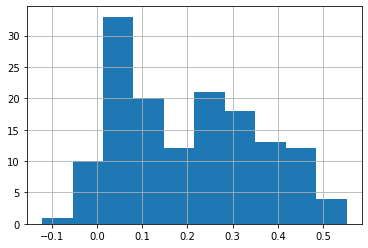

In [20]:
pd.Series(cosine_sim_bert).hist()

In [21]:
cosine_sim_bert_related = cosine_sim_bert[:int(len(test_set)/2)]
cosine_sim_bert_unrelated = cosine_sim_bert[int(len(test_set)/2):]

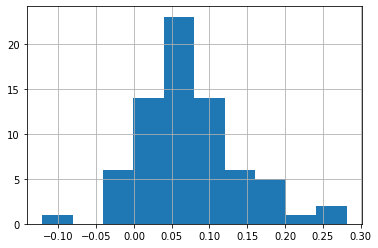

In [22]:
pd.Series(cosine_sim_bert_unrelated).hist()

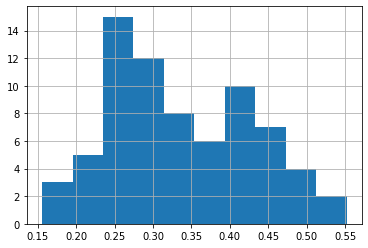

In [23]:
pd.Series(cosine_sim_bert_related).hist()

In [24]:
pd.Series(cosine_sim_bert_unrelated).describe()

count    72.000000
mean      0.071679
std       0.065623
min      -0.121429
25%       0.031881
50%       0.060105
75%       0.105090
max       0.281373
dtype: float64

In [25]:
pd.Series(cosine_sim_bert_related).describe()

count    72.000000
mean      0.337315
std       0.093603
min       0.155498
25%       0.267580
50%       0.320092
75%       0.404861
max       0.551982
dtype: float64

In [26]:
# 2 sample KS-test
stats.ks_2samp(cosine_sim_bert_related, cosine_sim_bert_unrelated)

Ks_2sampResult(statistic=0.9166666666666666, pvalue=1.5056433423673316e-32)

In [28]:
cosine_sim_bert_df = pd.DataFrame(cosine_sim_bert, columns=['Similarity'])
context = [None] * len(cosine_sim_bert)
context[:int(len(cosine_sim_bert)/2)] = ["Related"] * int(len(cosine_sim_bert)/2)
context[int(len(cosine_sim_bert)/2):] = ["Unrelated"] * int(len(cosine_sim_bert)/2)
cosine_sim_bert_df['Context'] = context
print(cosine_sim_bert_df.head())

   Similarity  Context
0    0.217674  Related
1    0.346757  Related
2    0.397954  Related
3    0.466758  Related
4    0.401709  Related


In [31]:
cosine_sim_bert_df.to_csv("cosine_sim_bert.csv", index=False)

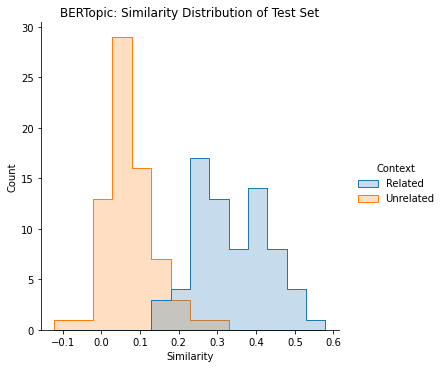

In [56]:
sns.displot(cosine_sim_bert_df, x="Similarity", hue="Context", element="step", binwidth=0.05).set(title='BERTopic: Similarity Distribution of Test Set')

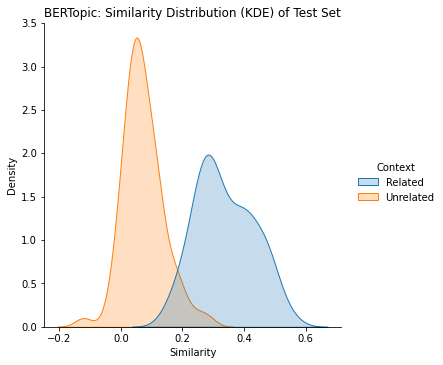

In [59]:
sns.displot(cosine_sim_bert_df, x="Similarity", hue="Context", kind="kde", fill=True).set(title='BERTopic: Similarity Distribution (KDE) of Test Set')

[Text(0.5, 1.0, 'BERTopic: Boxplot of Similarity for Test Set')]

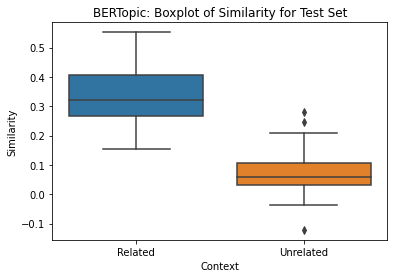

In [58]:
sns.boxplot(data=cosine_sim_bert_df, x='Context', y='Similarity').set(title='BERTopic: Boxplot of Similarity for Test Set')

In [51]:
# Save model
topic_model.save("bertopic_trained_alex_1023")

In [ ]:
# Load model
# bertopic_trained = BERTopic.load("bertopic_trained_alex_1023")

In [ ]:
#for i in range(len(test_set)):
#  topics, probs = topic_model.transform(filteredQ[i])
#  kwd = topic_model.get_topic(topics[0])[0][0]
#  similar_topics, similarity = topic_model.find_topics(kwd, top_n=5)
#  print(filteredQ[i])
#  print(topics)
#  print('Similarity for test set query {} = {}'.format(i, similarity[0]))

## Universal Sentence Encoder Evaluation

In [39]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [40]:
doc_filtered = [x.strip('\n') for x in train_set if x not in ['\n', '—\n']]

In [41]:
# Calculate embedding for training data
training_data_embed = embed(doc_filtered)

for i, message_embedding in enumerate(np.array(training_data_embed).tolist()):
  if i < 5:
    print("Message: {}".format(doc_filtered[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Hello. I'd like to show you guys 30 seconds of the best day of my life. Today I'd like to talk about howI was able to feel so comfortable and how I overcame my fear. 
Embedding size: 512
Embedding: [0.03032401204109192, -0.06691817939281464, -0.05921411141753197, ...]

Message: "I'll start with a very brief version of how I became a climber, and then tell the story of my two most significant free solos. They were both successful, which is why I'm here. "
Embedding size: 512
Embedding: [-0.02310863509774208, -0.08106034994125366, 0.03169097378849983, ...]

Message: "So that was El Capitan in California's Yosemite National Park, and in case you couldn't tell, I was climbing by myself without a rope, a style of a climbing known as free soloing. "
Embedding size: 512
Embedding: [-0.026742178946733475, -0.0424533486366272, 0.0641295462846756, ...]

Message: "That was the culmination of a nearly decade-long dream, and in the video I'm over 2,500 feet off the ground. Seems scary? Yea

In [42]:
# Calculate cos sim from question to embedded training data
test_embedding = embed(test_set)

In [ ]:
#cosine_scores = []
#for i in range(len(training_data_embed)):
#  cosine_scores.append(1-distance.cosine(training_data_embed[i], test_embedding[0]))

In [ ]:
#print("The index of the sentence with maximum cosine score is ", np.argmax(cosine_scores))
#print("The best cosine score ", np.max(cosine_scores))

In [ ]:
#train_set[415]

In [ ]:
#test_set[0]

In [43]:
cosine_sim_use4 = []
for sentence in range(len(test_embedding)):
  cosine_scores = []
  for i in range(len(training_data_embed)):
    cosine_scores.append(1-distance.cosine(training_data_embed[i], test_embedding[sentence]))
    
  cosine_sim_use4.append(np.max(cosine_scores))

In [40]:
#for i in range(len(cosine_sim_use4)):
#  print('Similarity for test set query {} = {}'.format(i, cosine_sim_use4[i]))

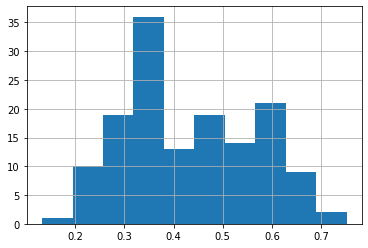

In [44]:
pd.Series(cosine_sim_use4).hist()

In [45]:
cosine_sim_use4_related = cosine_sim_use4[:int(len(test_set)/2)]
cosine_sim_use4_unrelated = cosine_sim_use4[int(len(test_set)/2):]

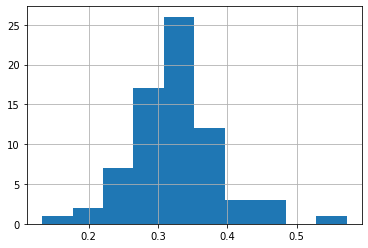

In [46]:
pd.Series(cosine_sim_use4_unrelated).hist()

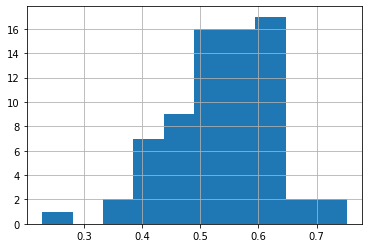

In [47]:
pd.Series(cosine_sim_use4_related).hist()

In [48]:
pd.Series(cosine_sim_use4_unrelated).describe()

count    72.000000
mean      0.325578
std       0.065994
min       0.132918
25%       0.288322
50%       0.332385
75%       0.354799
max       0.572018
dtype: float64

In [49]:
pd.Series(cosine_sim_use4_related).describe()

count    72.000000
mean      0.538415
std       0.092161
min       0.227655
25%       0.485563
50%       0.545929
75%       0.610580
max       0.751631
dtype: float64

In [ ]:
# KS statistic
# Plot Precision, Recall, F1, confusion metrix
# Combine cosine scores from both models (ensemble) as new scores, or take the minimum, take the max -> use geometric means or normalize with their means

In [50]:
stats.ks_2samp(cosine_sim_use4_related, cosine_sim_use4_unrelated)

Ks_2sampResult(statistic=0.8472222222222222, pvalue=1.263211338782241e-26)

In [51]:
cosine_sim_use4_df = pd.DataFrame(cosine_sim_use4, columns=['Similarity'])
context = [None] * len(cosine_sim_use4)
context[:int(len(cosine_sim_use4)/2)] = ["Related"] * int(len(cosine_sim_use4)/2)
context[int(len(cosine_sim_use4)/2):] = ["Unrelated"] * int(len(cosine_sim_use4)/2)
cosine_sim_use4_df['Context'] = context
print(cosine_sim_use4_df.head())

   Similarity  Context
0    0.431183  Related
1    0.545978  Related
2    0.656766  Related
3    0.559016  Related
4    0.593796  Related


In [52]:
cosine_sim_use4_df.to_csv("cosine_sim_use4.csv", index=False)

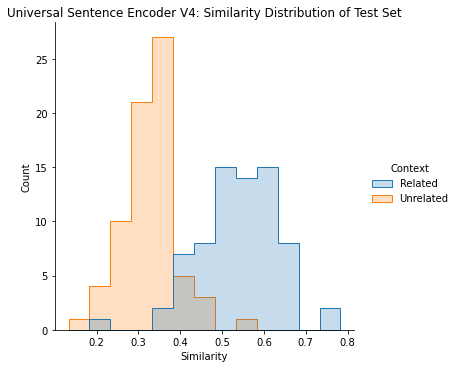

In [53]:
sns.displot(cosine_sim_use4_df, x="Similarity", hue="Context", element="step", binwidth=0.05).set(title='Universal Sentence Encoder V4: Similarity Distribution of Test Set')

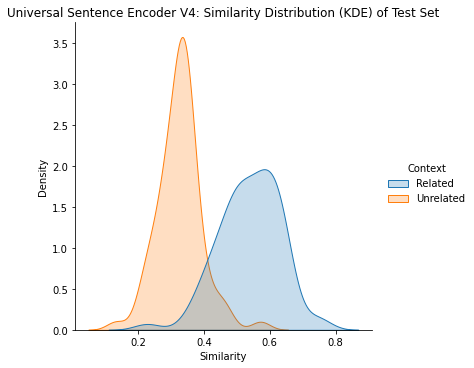

In [60]:
sns.displot(cosine_sim_use4_df, x="Similarity", hue="Context", kind="kde", fill=True).set(title='Universal Sentence Encoder V4: Similarity Distribution (KDE) of Test Set')

[Text(0.5, 1.0, 'Universal Sentence Encoder V4: Boxplot of Similarity for Test Set')]

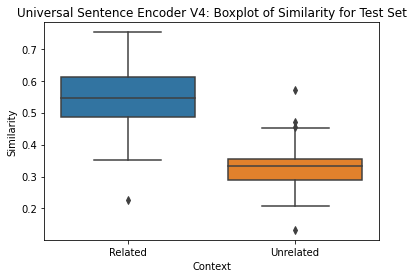

In [55]:
sns.boxplot(data=cosine_sim_use4_df, x='Context', y='Similarity').set(title='Universal Sentence Encoder V4: Boxplot of Similarity for Test Set')